# Dogs in Vienna: Sample Open Data Analysis Script
This is a sample script showing how an open data datasets can be analysed and demonstrated using [Jupiter Notebooks](http://jupyter.org). Similar examples can be found on [Kaggle web-site](https://www.kaggle.com/kernels). We take the dog statistics data in Vienna as a sample use case to demonstrate common approaches to analysing open data.

## Open Data Story
It is useful to define a set of possible research questions that define the goal of the data study and refine them along the way since the availablity of data suggests possible ways to combine and explore it.

### Research Questions
1. How many dogs are there in Vienna?
2. Which dogs do Viennese people like?
3. Where should I take my dog to find a couple?
4. Where should I live if I do not like dogs?
5. Do dog preferences vary across districts and why?
6. Why some districts have more/less dogs than others?
7. What is the dog situation in my district?

In [2]:
# Load libraries
import pandas as pd # CSV file processing
import numpy as np # vector and matrix manipulation
import matplotlib.pyplot as plt # visualisation
import seaborn as sns # visualisation
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Get the Data
Let's load a dataset and make sure it is loaded correctly, so that we can use it for our analysis. It is often not that trivial as it may seem and involves a lot of data wrangling and debugging in order to find and eliminate possible errors or inconsistences in the dataset. 

This step should not be underestimated since it defines the final result of our data analysis.
Remember: "Garbage in,  garbage out!"

In [275]:
# Load the csv file from the open data portal
# dataset description: https://www.data.gv.at/katalog/dataset/stadt-wien_anzahlderhundeprobezirkderstadtwien/resource/b8d97349-c993-486d-b273-362e0524f98c
data_path = 'https://www.wien.gv.at/finanzen/ogd/hunde-wien.csv'
# Look up the row file and specify the dataset format, e.g. delimiters
data = pd.read_csv(data_path, delimiter=';', encoding='latin-1')
data.head()

,Hunderassen in Wien | Breed of Dogs in Vienna,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
1,AT1,AT13,AT113,90100,.,1010,Afghanischer Windhund,1,20161201
2,AT1,AT13,AT113,90100,.,1010,Amerikanischer Pit-Bullterrier,1,20161201
3,AT1,AT13,AT113,90100,.,1010,Amerikanischer Staffordshire-Terrier,4,20161201
4,AT1,AT13,AT113,90100,.,1010,Amerikanischer Staffordshire-Terrier / Mischling,1,20161201


Oops the first row of our CSV file contains the name of the table, which we should skip.

In [276]:
# Reload dataset
data = pd.read_csv(data_path, delimiter=';', skiprows=1, encoding='latin-1')
# Check the top of the table to make sure the dataset is loaded correctly 
data.head()

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,AT1,AT13,AT113,90100,.,1010,Afghanischer Windhund,1,20161201
1,AT1,AT13,AT113,90100,.,1010,Amerikanischer Pit-Bullterrier,1,20161201
2,AT1,AT13,AT113,90100,.,1010,Amerikanischer Staffordshire-Terrier,4,20161201
3,AT1,AT13,AT113,90100,.,1010,Amerikanischer Staffordshire-Terrier / Mischling,1,20161201
4,AT1,AT13,AT113,90100,.,1010,Australian Shepherd Dog,3,20161201


It seems that the mixed breeds are entered using sign '/', e.g. Amerikanischer Staffordshire-Terrier / Mischling
Let's simplify it and take only the first breed in all these cases.

In [277]:
separate_breeds = data['Dog Breed'].str.split('/', return_type='frame')
separate_breeds.columns = ["Breed_1", "Breed_2", "Breed_3"]
# data_breeds[2].unique()
data_breeds = pd.concat([data, separate_breeds], axis=1)
data_breeds.head()


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: the return_type='frame' keyword is deprecated, use expand=True instead
  if __name__ == '__main__':


,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date,Breed_1,Breed_2,Breed_3
0,AT1,AT13,AT113,90100,.,1010,Afghanischer Windhund,1,20161201,Afghanischer Windhund,None,None
1,AT1,AT13,AT113,90100,.,1010,Amerikanischer Pit-Bullterrier,1,20161201,Amerikanischer Pit-Bullterrier,None,None
2,AT1,AT13,AT113,90100,.,1010,Amerikanischer Staffordshire-Terrier,4,20161201,Amerikanischer Staffordshire-Terrier,None,None
3,AT1,AT13,AT113,90100,.,1010,Amerikanischer Staffordshire-Terrier / Mischling,1,20161201,Amerikanischer Staffordshire-Terrier,Mischling,None
4,AT1,AT13,AT113,90100,.,1010,Australian Shepherd Dog,3,20161201,Australian Shepherd Dog,None,None


The top rows look just fine. But what about the rest?

In [278]:
data.shape

(5740, 9)

Our dataset contains 5740 rows and 9 columns.

In [279]:
# Check the column types to make sure the dataset is loaded correctly
data.dtypes

NUTS1                object
NUTS2                object
NUTS3                object
DISTRICT_CODE         int64
SUB_DISTRICT_CODE    object
Postal_CODE           int64
Dog Breed            object
Anzahl               object
Ref_Date              int64
dtype: object

Count (Anzahl) is not recognized as numeric data. We shall fix this!

In [280]:
# Check the rows that are not recognized as numeric
data[data.Anzahl.apply(lambda x: not x.isnumeric())]

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
1914,AT1,AT13,AT113,91000,.,1100,Unbekannt,"1,51",20161201
2210,AT1,AT13,AT113,91100,.,1110,Unbekannt,"1,029",20161201
4879,AT1,AT13,AT113,92100,.,1210,Unbekannt,"2,066",20161201
5347,AT1,AT13,AT113,92200,.,1220,Unbekannt,"2,46",20161201
5715,AT1,AT13,AT113,92300,.,1230,Unbekannt,"1,215",20161201


Hmmm that looks interesting. 1,51 of a dog. What could that possibly mean?

Maybe 0s in the end of thousands got accidentally droped?
This does indeed look like a plausible explanation for these numbers. Lets try to fix this.

In [281]:
# Reload dataset
data = pd.read_csv(data_path, delimiter=';', skiprows=1, thousands=',', encoding='latin-1')
# Check the column types to make sure the dataset is loaded correctly
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5740 entries, 0 to 5739
Data columns (total 9 columns):
NUTS1                5740 non-null object
NUTS2                5740 non-null object
NUTS3                5740 non-null object
DISTRICT_CODE        5740 non-null int64
SUB_DISTRICT_CODE    5740 non-null object
Postal_CODE          5740 non-null int64
Dog Breed            5740 non-null object
Anzahl               5740 non-null int64
Ref_Date             5740 non-null int64
dtypes: int64(4), object(5)
memory usage: 403.7+ KB


Looks good: count is recognized as integer (Anzahl int64).
But I want to make sure the numbers were translated correctly. Lets find these rows.

In [282]:
# Filter raws based on multiple columns
data[(data['Dog Breed']=='Unbekannt') & (data['Postal_CODE']==1100)]

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
1914,AT1,AT13,AT113,91000,.,1100,Unbekannt,151,20161201


Oh no that did not work magic. We need to fix these cases manually.

In [283]:
# Correct individual values in the dataset
data['Anzahl'][1914] = 1510
data['Anzahl'][5347] = 2460
# Filter raws based on multiple columns
data[(data['Dog Breed']=='Unbekannt') & (data['Postal_CODE']==1100)]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
1914,AT1,AT13,AT113,91000,.,1100,Unbekannt,1510,20161201


In [312]:
# Carefully select the string separator, including spaces!
separate_breeds = data['Dog Breed'].str.split(' / ', return_type='frame')
separate_breeds.columns = ["Breed_1", "Breed_2"]
# data_breeds[2].unique()
data_breeds = pd.concat([data, separate_breeds], axis=1)
data_breeds.head()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: the return_type='frame' keyword is deprecated, use expand=True instead
  if __name__ == '__main__':


,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date,Breed_1,Breed_2
0,AT1,AT13,AT113,90100,.,1010,Afghanischer Windhund,1,20161201,Afghanischer Windhund,None
1,AT1,AT13,AT113,90100,.,1010,Amerikanischer Pit-Bullterrier,1,20161201,Amerikanischer Pit-Bullterrier,None
2,AT1,AT13,AT113,90100,.,1010,Amerikanischer Staffordshire-Terrier,4,20161201,Amerikanischer Staffordshire-Terrier,None
3,AT1,AT13,AT113,90100,.,1010,Amerikanischer Staffordshire-Terrier / Mischling,1,20161201,Amerikanischer Staffordshire-Terrier,Mischling
4,AT1,AT13,AT113,90100,.,1010,Australian Shepherd Dog,3,20161201,Australian Shepherd Dog,None


In [354]:
# Check unique values
data_breeds['Breed_1'].unique()

array([u'Afghanischer Windhund', u'Amerikanischer Pit-Bullterrier',
       u'Amerikanischer Staffordshire-Terrier', u'Australian Shepherd Dog',
       u'Australian Terrier', u'Basset Hound', u'Beagle', u'Beauceron',
       u'Bergamasker Hirtenhund', u'Berner Sennenhund', u'Bernhardiner',
       u'Bichon Fris\xc3\xa9', u'Bolonka Zwetna', u'Border-Collie',
       u'Bosnischer Rauhhaariger Laufhund', u'Boston Terrier', u'Boxer',
       u'Bracke', u'Bulldog', u'Bullterrier', u'Cairn-Terrier',
       u'Cao de Agua Portugues', u'Cavalier King Charles Spaniel',
       u'Chihuahua kurzhaariger Schlag', u'Chihuahua langhaariger Schlag',
       u'Chow-Chow', u'Cockerpoo', u'Collie', u'Dackel', u'Dalmatiner',
       u'Deutsche Dogge', u'Deutscher Jagdterrier', u'Deutscher Pinscher',
       u'Deutscher Sch\xc3\xa4ferhund', u'Deutsch Kurzhaar',
       u'Dogo Argentino', u'Drahthaar-Foxterrier',
       u'Englischer Cockerspaniel', u'Entlebucher Sennenhund',
       u'Flat Coated Retriever', u'Franz\x

In [317]:
# Check descriptive statistics
data_breeds.describe()
# data['Ref_Date'].unique()

,DISTRICT_CODE,Postal_CODE,Anzahl,Ref_Date
count,5740.000000,5740.000000,5740.000000,5740.0
mean,91355.000000,1135.500000,9.743728,20161201.0
std,668.274742,66.827474,61.095023,0.0
min,90100.000000,1010.000000,1.000000,20161201.0
25%,90900.000000,1090.000000,1.000000,20161201.0
50%,91400.000000,1140.000000,2.000000,20161201.0
75%,92000.000000,1200.000000,5.000000,20161201.0
max,92300.000000,1230.000000,2460.000000,20161201.0


The district and postal codes range from 90100 (1010) to 92300 (1230) indicating the 23 districts of Vienna (Wiener Bezirke).

All rows describe the data for a single reference date: 2016 12 01. Since the date format is not explicitly specified, it is not clear though whether it is the 1st of December or the 12th of January.

Essentially the dataset boils down to the information: District | Dog Breed | Dog Count

In [364]:
data_breed_1 = data_breeds.groupby(['DISTRICT_CODE', 'Breed_1'])['Anzahl'].aggregate(np.sum).reset_index()
data_breed_1

,DISTRICT_CODE,Breed_1,Anzahl
0,90100,Afghanischer Windhund,1
1,90100,Amerikanischer Pit-Bullterrier,1
2,90100,Amerikanischer Staffordshire-Terrier,5
3,90100,Australian Shepherd Dog,3
4,90100,Australian Terrier,1
5,90100,Basset Hound,1
6,90100,Beagle,8
7,90100,Beauceron,1
8,90100,Bergamasker Hirtenhund,1
9,90100,Berner Sennenhund,1


Now the data is ready to be analysed.

### Analyse the Data
#### 1. How many dogs live in Vienna?

This question is simple to answer using simple column statistics.

In [365]:
sum(data_breed_1['Anzahl'])

55929

Almost 56 thousand dogs are registered in Vienna.

#### 2. Which dog breeds are the most popular in Vienna?

Lets have a look at our dataset closer.

In [366]:
# Check the top counts
sorted_count = data_breed_1.sort_values(['Anzahl'], ascending=False)
sorted_count.head()

,DISTRICT_CODE,Breed_1,Anzahl
3251,92200,Unbekannt,2460
3025,92100,Unbekannt,2066
1244,91000,Unbekannt,1510
3447,92300,Unbekannt,1215
1412,91100,Unbekannt,1029


Most of the dog breeds is unfortunately unknown (Unbekannt). It is not clear though, whether we do not know the breed of a dog or they do not know their breed themselves.

Let's exclude the unknown and check how many different breeds we have in total

In [371]:
# Filter out specific rows
filtered_dogs = sorted_count[(data_breed_1['Breed_1']!='Unbekannt')]
# Check unique values in one of the columns
unique_breeds = filtered_dogs['Breed_1'].unique()
len(unique_breeds)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


320

We have dogs of 320 different breeds living in Vienna. How cool is that!

In [373]:
filtered_dogs.head()

,DISTRICT_CODE,Breed_1,Anzahl
3179,92200,Labrador Retriever,481
3105,92200,Chihuahua kurzhaariger Schlag,473
2897,92100,Chihuahua kurzhaariger Schlag,450
2964,92100,Labrador Retriever,363
1111,91000,Chihuahua kurzhaariger Schlag,344


"Chihuahua here. Chihuahua there. Everybody wants it everywhere."

Indeed, especially in the 10th, 21st and 22nd districts of Vienna. And most of the Labradors live in 21st and 22nd districts.

Now you know where to go if you enjoy dog-watching!

[<matplotlib.text.Text at 0x12ee16750>, <matplotlib.text.Text at 0x12eeb4f50>]

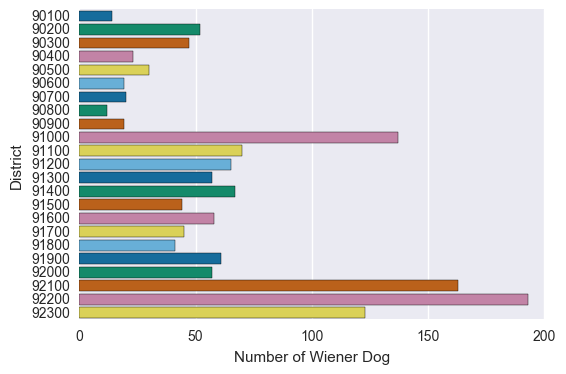

In [481]:
# Filter
dackel = filtered_dogs[(filtered_dogs['Breed_1']=='Dackel')]
# Sort
dackel = dackel.sort_values(ascending=False, by='Anzahl')
# Plot
ax = sns.barplot(palette='colorblind', data=dackel, y=dackel.DISTRICT_CODE, x=dackel.Anzahl, orient='h')
ax.set(ylabel='District', xlabel='Number of Wiener Dog')
# TODO discount by number of all dogs, and number of people

By aggregating over districts we obtain a rating for the most popular dog breeds in whole Vienna:

In [375]:
breeds = filtered_dogs.groupby('Breed_1')['Anzahl'].aggregate(np.sum)
breeds.sort_values(ascending=False).head()

Breed_1
Labrador Retriever               3110
Chihuahua kurzhaariger Schlag    2925
Golden Retriever                 1798
Malteser                         1745
Deutscher SchÃ¤ferhund           1698
Name: Anzahl, dtype: int64

[<matplotlib.text.Text at 0x124768350>, <matplotlib.text.Text at 0x12475ae10>]

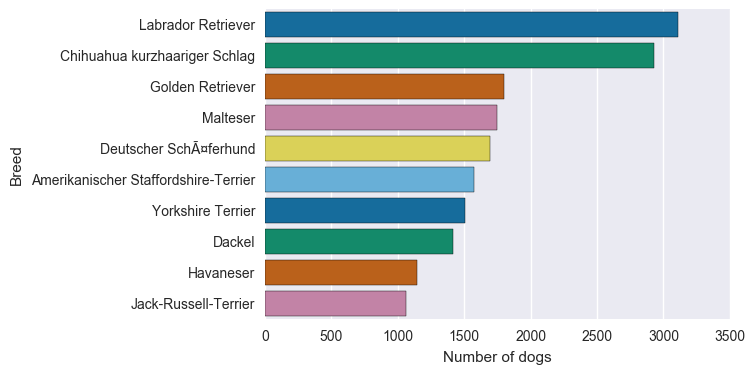

In [376]:
# Filter, sort and trim pandas Series
top_dogs = breeds.sort_values(ascending=False)[:10]
# Plot pandas Series
ax = sns.barplot(palette='colorblind', x=top_dogs.values, y=list(top_dogs.index))
ax.set(ylabel='Breed', xlabel='Number of dogs')

Labradors and Chihuahuas are the top dog-pets among Viennese people. 

Wiener dog (Dackel) landed at position #8 in our Viennese dogs ranking. Sad... :(

##### Where should I take my dog to find a couple?
What if you are a proud owner of a dog of a very rare breed? 

Well ... you may have serious troubles finding a good match if you ever decide to have puppies!

Good news: open data can help you with this!

In [378]:
# Check the outliers in the tail of the distribution
rare_dogs = breeds[breeds == 2]
rare_dogs.head()

Breed_1
Ainu-Hund                    2
AlpinschÃ¤fer                2
AltdÃ¤nischer Vorstehhund    2
American Foxhound            2
American Water Spaniel       2
Name: Anzahl, dtype: int64

In [379]:
data_breeds[(data_breeds['Breed_1']=='American Water Spaniel')]['DISTRICT_CODE']

3959    91900
4930    92200
Name: DISTRICT_CODE, dtype: int64

For the two beautiful American Water Spaniels to meet they need to cross the Danube comming from the 22nd to 19th district. 

Alas! There is no information on the dog gender in our dataset unfortunatelly so this huge effort might not pay off.

##### Where should I live if I do not like dogs?
Now let's do the same trick but on the level of districts instead of breeds. Instead we want to aggregate dogs of all breeds for each of the districts of Vienna separately to obtain dogs per district counts.

[<matplotlib.text.Text at 0x122dbbdd0>, <matplotlib.text.Text at 0x122e2e790>]

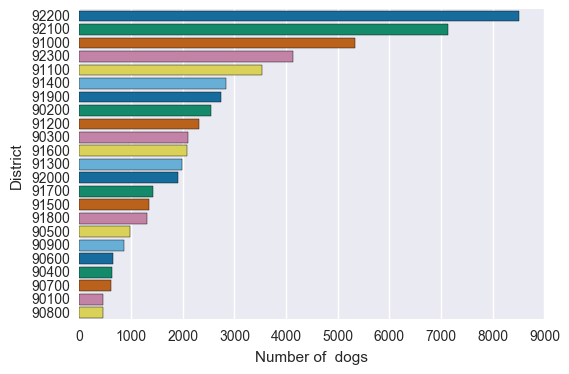

In [380]:
district_dogs = data_breeds.groupby('DISTRICT_CODE')['Anzahl'].aggregate(np.sum)
# Filter, sort and trim pandas Series
top_dogs = district_dogs.sort_values(ascending=False)
# Plot pandas Series
ax = sns.barplot(palette='colorblind', y=list(top_dogs.index), x=top_dogs.values, orient='h', order=list(top_dogs.index))
ax.set(ylabel='District', xlabel='Number of  dogs')

OK. 22nd and 21st district of Vienna are the most rich in dogs (8,5 and 7 thousands respectively). 10th, 23rd and 11th districts follow in the dog ranking. 

You are the least likely to see a dog, when visiting 1st and 8th districts of Vienna (also, 4th, 6th and 7th).

What could be the possible reasons for such variation in the number of dogs in different districts of Vienna (500-8,500 dogs per district)? We shall need more data to analyse these trends...

### Get More Data
Districts of any city (town) are not homogeneous in terms of area and population. Also in Vienna some districts are bigger in terms of territory, more densely populated or wealthier than other district. These factors shall also have an effect on the dog population within the specified regions. 

Now we need to fetch this kind of data (population, area and average income per district in Vienna) in order to check its correlation with our dog stats data. https://www.data.gv.at is the biggest Austrian open data portal. Let's have a look there! 

#### Population Statistics per District
Population (Bevölkerung) seems just right for the general category, filtering on Vienna, CSV data format and community districts (Gemeindebezirke) boils down the search results to a single dataset!

Next, we just repeat the same steps we used previously to obtain the dog data:

In [327]:
# Load the csv file from the open data portal
# Dataset description: https://www.data.gv.at/katalog/dataset/stadt-wien_viebevlkerungseit1869wien/resource/c9e9d0cc-8f71-4521-b598-17d71fab2f59
data_path = 'https://www.wien.gv.at/statistik/ogd/vie_101.csv'
# Look up the row file and specify the dataset format, e.g. delimiters
data_population = pd.read_csv(data_path, delimiter=';', skiprows=1)
# Check the top of the table to make sure the dataset is loaded correctly 
data_population.head()

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,POP_TOTAL,POP_MEN,POP_WOMEN,REF_DATE
0,AT1,AT13,AT130,90100,.,68079,.,.,18691231
1,AT1,AT13,AT130,90200,.,68442,.,.,18691231
2,AT1,AT13,AT130,90300,.,88678,.,.,18691231
3,AT1,AT13,AT130,90400,.,55682,.,.,18691231
4,AT1,AT13,AT130,90500,.,54010,.,.,18691231


We would prefer the most recent population data to be able to compare with the dog stats from 2016 12 01. 

It is not clear from the description of the dataset which time periods are covered either:
"VIE-Bevölkerung in den 23 Wiener Gemeindebezirken nach Geschlecht seit 1869
    Zuletzt aktualisiert	31. März 2016
    Erstellt	31. März 2016"

In [328]:
# Check unique column values
data_population['REF_DATE'].unique()

array([18691231, 18801231, 19001231, 19101231, 19230307, 19340322,
       19390517, 19510601, 19610321, 19710512, 19810512, 19910515,
       20010515, 20020101, 20030101, 20040101, 20050101, 20060101,
       20070101, 20080101, 20090101, 20100101, 20110101, 20120101,
       20130101, 20140101, 20150101])

The last measurement is from 2015 (same as on Wikipedia: https://de.wikipedia.org/wiki/Wiener_Gemeindebezirke#cite_note-11). Let's take it.

In [329]:
# Slice dataset: filter specific rows and columns
population_2015 = data_population[(data_population['REF_DATE'] == 20150101)][['DISTRICT_CODE', 'POP_TOTAL']]
# Sort column
population_2015.sort_values(ascending=False, by='POP_TOTAL').head()

,DISTRICT_CODE,POP_TOTAL
630,91000,189713
642,92200,172978
641,92100,151844
622,90200,101702
636,91600,100738


Very good we have the population count per district. Let's compare it with the dog counts. For this we need to join the datasets on the common column, which is the DISTRICT_CODE.

In [330]:
# Join Data Frame and Series objects on the key column
dog_vs_people = population_2015.join(district_dogs, on='DISTRICT_CODE')
dog_vs_people.sort_values(ascending=False, by='POP_TOTAL').head()

,DISTRICT_CODE,POP_TOTAL,Anzahl
630,91000,189713,5333
642,92200,172978,8504
641,92100,151844,7143
622,90200,101702,2545
636,91600,100738,2077


In [331]:
dog_vs_people[['POP_TOTAL', 'Anzahl']].corr()

,POP_TOTAL,Anzahl
POP_TOTAL,1.000000,0.903501
Anzahl,0.903501,1.000000


As expected, dog population is positively correlated with human population (we usually live together).

Therefore, estimating proportion of dogs to people is a reasonable way to compare between different districts.

In [332]:
dog_vs_people['Dogs_per_person'] = dog_vs_people.Anzahl / dog_vs_people.POP_TOTAL
# Sort by column
dog_vs_people.sort_values(ascending=True, by='Dogs_per_person').round(3).head()

,DISTRICT_CODE,POP_TOTAL,Anzahl,Dogs_per_person
635,91500,76320,1352,0.018
625,90500,54246,982,0.018
628,90800,24518,459,0.019
627,90700,31291,619,0.020
624,90400,31691,632,0.020


If you prefer people to dogs you would feel better in 5th and 15th districts.

In [333]:
# Sort by column
dog_vs_people.sort_values(ascending=False, by='Dogs_per_person').round(3).head()

,DISTRICT_CODE,POP_TOTAL,Anzahl,Dogs_per_person
642,92200,172978,8504,0.049
641,92100,151844,7143,0.047
643,92300,96775,4136,0.043
639,91900,69999,2745,0.039
633,91300,52115,1990,0.038


22nd and 21st districts have the biggest dog populations relative to the number of inhabitants in the district: 49 and 47 dogs per 1000 people respectively.

These districts are also the largest in terms of territory. Let's get this data into play as well!

#### Area Statistics per District
Getting back to https://www.data.gv.at. Ok this one was not easy to find!
TODO
and
#### Hundezonen in Wien
TODO
https://www.wien.gv.at/umwelt/parks/hundezonen.html
https://www.wien.gv.at/statistik/lebensraum/tabellen/hundezonen-bez.html

#### Income Statistics per District
This dataset was relatively easy to find when searching with the keyword 'income' (einkommen) on https://www.data.gv.at portal.

In [334]:
# Load the csv file from the open data portal
# Dataset description: https://www.data.gv.at/katalog/dataset/stadt-wien_viewirtschaftwienergemeindebezirke1/resource/c1ad52a3-ca5c-44fc-a945-b6459f73ed98
data_path = 'https://www.wien.gv.at/statistik/ogd/vie_502.csv'
# The data format seems to be consistent for all the datasets from this publisher 
data_income = pd.read_csv(data_path, delimiter=';', skiprows=1)
# Check the top of the table to make sure the dataset is loaded correctly 
data_income.head()

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,INCOME_TOTAL,INCOME_MEN,INCOME_WOMEN,AVERAGE_INCOME_TOTAL,AVERAGE_INCOME_MEN,AVERAGE_INCOME_WOMEN,AVERAGE_INCOME_FULLTIME_TOTAL,AVERAGE_INCOME_FULLTIME_MEN,AVERAGE_INCOME_FULLTIME_WOMEN,REF_DATE
0,AT1,AT13,AT130,90100,.,292.103.000,194.301.000,97.802.000,25.463,31.961,18.536,34.506,42.806,24.963,20021231
1,AT1,AT13,AT130,90200,.,919.962.000,559.682.000,360.280.000,16.439,18.301,14.282,22.015,24.312,19.067,20021231
2,AT1,AT13,AT130,90300,.,1.011.882.000,608.994.000,402.888.000,18.701,21.444,15.804,24.617,27.968,20.739,20021231
3,AT1,AT13,AT130,90400,.,402.479.000,243.807.000,158.672.000,20.325,23.641,16.876,27.348,31.586,22.539,20021231
4,AT1,AT13,AT130,90500,.,554.361.000,327.128.000,227.233.000,16.258,17.937,14.395,22.059,24.198,19.454,20021231


In [335]:
# Check unique column values
data_income['REF_DATE'].unique()

array([20021231, 20031231, 20041231, 20051231, 20061231, 20071231,
       20081231, 20091231, 20101231, 20111231, 20121231, 20131231, 20141231])

The last measurement is from 2014. Let's take it.

In [336]:
# Slice dataset: filter specific rows and columns
income_2014 = data_income[(data_income['REF_DATE'] == 20141231)][['DISTRICT_CODE', 'AVERAGE_INCOME_TOTAL']]
# Sort column
income_2014.sort_values(ascending=False, by='AVERAGE_INCOME_TOTAL').head()
# income_2014.sort_values(ascending=True, by='AVERAGE_INCOME_TOTAL').head()

,DISTRICT_CODE,AVERAGE_INCOME_TOTAL
276,90100,32.493
288,91300,27.604
294,91900,25.803
279,90400,24.199
293,91800,24.164


All right, this is common knowledge ;)  The wealthiest are 1st and 13th, the poorest are 15th and 20th districts of Vienna. 

[<matplotlib.text.Text at 0x11d320850>, <matplotlib.text.Text at 0x126995590>]

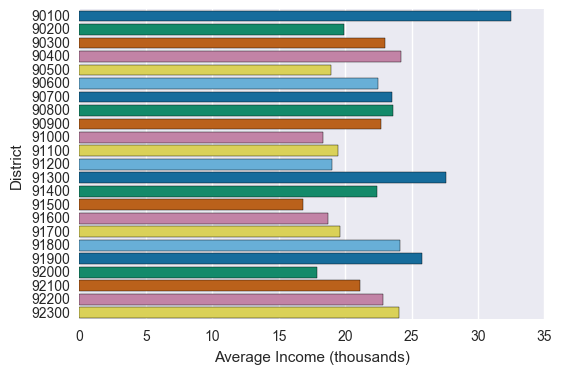

In [337]:
# Plot pandas data frame
ax = sns.barplot(data=income_2014,palette='colorblind', y='DISTRICT_CODE', x='AVERAGE_INCOME_TOTAL', orient='h')
ax.set(ylabel='District', xlabel='Average Income (thousands)')

Let's join our data sets with district stats.

In [338]:
# Merge data frames on the key column
dog_vs_people_vs_income = dog_vs_people.merge(income_2014, on='DISTRICT_CODE')
dog_vs_people_vs_income.sort_values(ascending=False, by='AVERAGE_INCOME_TOTAL').head()

,DISTRICT_CODE,POP_TOTAL,Anzahl,Dogs_per_person,AVERAGE_INCOME_TOTAL
0,90100,16339,465,0.028460,32.493
12,91300,52115,1990,0.038185,27.604
18,91900,69999,2745,0.039215,25.803
3,90400,31691,632,0.019943,24.199
17,91800,49178,1316,0.026760,24.164


In [339]:
dog_vs_people_vs_income.corr()

,DISTRICT_CODE,POP_TOTAL,Anzahl,Dogs_per_person,AVERAGE_INCOME_TOTAL
DISTRICT_CODE,1.000000,0.453962,0.563003,0.592619,-0.213271
POP_TOTAL,0.453962,1.000000,0.903501,0.554129,-0.455340
Anzahl,0.563003,0.903501,1.000000,0.813967,-0.178365
Dogs_per_person,0.592619,0.554129,0.813967,1.000000,0.273133
AVERAGE_INCOME_TOTAL,-0.213271,-0.455340,-0.178365,0.273133,1.000000


There is no strong correlation between the average income and the number of dogs. However, income is negatively correlated with population count (nothing new here).

Everyone likes to have a dog. Maybe different kind of dog though...

Is there a correlation between specific dog breeds and the income of their owners?

Very likely, there is. Some dogs are very expensive... Which dogs are they?

In [422]:
# Create a “pivot” table based on column values
unfolded_breeds = filtered_dogs.pivot_table(index='DISTRICT_CODE', columns='Breed_1', values='Anzahl').fillna(0)
unfolded_breeds.reset_index(level=0, inplace=True)
unfolded_breeds.head()

Breed_1,DISTRICT_CODE,Affenpinscher,Afghanischer Windhund,Ainu-Hund,Airedale-Terrier,Akita Inu,Alaskan Malamute,AlpenlÃ¤ndische Dachsbracke,AlpinschÃ¤fer,AltdÃ¤nischer Vorstehhund,...,Wolfsspitz,WÃ¤ller,Yorkshire Terrier,Zentralasiatischer Owtscharka,Zwergpinscher,Zwergpudel,Zwergschnauzer,ZwergschÃ¤ferhund,Zwergspitz,Ãsterreichischer Pinscher
0,90100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0.0,3.0,2.0,3.0,0.0,4.0,1.0
1,90200,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,1.0,...,1.0,0.0,85.0,0.0,41.0,4.0,7.0,0.0,27.0,6.0
2,90300,0.0,1.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,1.0,40.0,0.0,33.0,8.0,5.0,0.0,10.0,4.0
3,90400,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12.0,0.0,5.0,1.0,4.0,0.0,6.0,1.0
4,90500,0.0,0.0,0.0,2.0,5.0,0.0,2.0,0.0,0.0,...,0.0,0.0,24.0,0.0,19.0,0.0,2.0,0.0,4.0,1.0


In [416]:
breeds_vs_income = unfolded_breeds.merge(income_2014, on='DISTRICT_CODE')
# breeds_vs_income.head()
c = breeds_vs_income.corr()#.abs()

s = c.unstack()
so = s.order(kind="quicksort")
so.sort_values(ascending=False)['AVERAGE_INCOME_TOTAL']#[:20]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: order is deprecated, use sort_values(...)


Breed_1
AVERAGE_INCOME_TOTAL                                   1.000000
Bergamasker Hirtenhund                                 0.550433
Lurcher                                                0.489959
Australian Terrier                                     0.458564
Cockerpoo                                              0.454458
Skye Terrier                                           0.343452
Glen of Imaal Terrier                                  0.334978
Wachtelhund                                            0.334978
Tiroler Bracke                                         0.334978
Polnische Bracke                                       0.333029
Irish Terrier                                          0.322510
Norwich-Terrier                                        0.316258
American Toy Terrier                                   0.312786
Bayerischer Gebirgsschweisshund                        0.312219
Leonberger                                             0.308886
Weimaraner                      

In [465]:
# Select data slice
filtered_dogs[(filtered_dogs['Breed_1']=='Dogo Canario')]

,DISTRICT_CODE,Breed_1,Anzahl
1483,91200,Dogo Canario,3
3130,92200,Dogo Canario,2
2115,91600,Dogo Canario,2
3340,92300,Dogo Canario,2
1325,91100,Dogo Canario,2
162,90200,Dogo Canario,1
2920,92100,Dogo Canario,1
1982,91500,Dogo Canario,1
2586,91900,Dogo Canario,1
1130,91000,Dogo Canario,1


In [470]:
# Filter out small (unrepresentative) counts
common_dogs = filtered_dogs[(filtered_dogs['Anzahl']>10)]
top_dogs = common_dogs['Breed_1'].unique()
len(top_dogs)

86

[<matplotlib.text.Text at 0x12cab1cd0>, <matplotlib.text.Text at 0x12cab1290>]

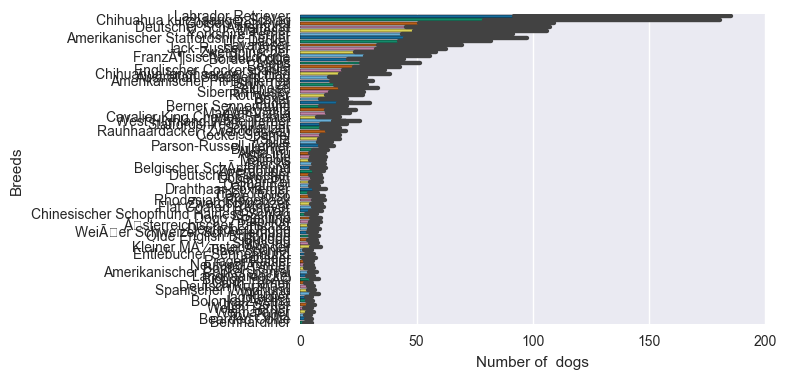

In [468]:
# Filter column with several values
labrador_vs_chihuahua = filtered_dogs[(filtered_dogs['Breed_1'].isin(top_dogs))]
ax = sns.barplot(data=labrador_vs_chihuahua,palette='colorblind', x='Anzahl', y='Breed_1')
ax.set(ylabel='Breeds', xlabel='Number of  dogs')

Chihuahua experiences the highest variation across districts. You either love it or nor.

In [471]:
# Create a “pivot” table based on column values
unfolded_breeds = common_dogs.pivot_table(index='DISTRICT_CODE', columns='Breed_1', values='Anzahl').fillna(0)
unfolded_breeds.reset_index(level=0, inplace=True)
# unfolded_breeds.head()

breeds_vs_income = unfolded_breeds.merge(income_2014, on='DISTRICT_CODE')
c = breeds_vs_income.corr()

s = c.unstack()
so = s.order(kind="quicksort")
so.sort_values(ascending=False)['AVERAGE_INCOME_TOTAL']

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: order is deprecated, use sort_values(...)


Breed_1
AVERAGE_INCOME_TOTAL                    1.000000
Entlebucher Sennenhund                  0.270323
Irish Setter                            0.236472
Flat Coated Retriever                   0.209285
Weimaraner                              0.194436
Collie                                  0.164491
WeiÃer Schweizer SchÃ¤ferhund          0.093471
Magyar Vizsla                           0.091800
Whippet                                 0.065475
Akita Inu                               0.054326
Berner Sennenhund                       0.051675
Hovawart                                0.051256
Parson-Russell-Terrier                  0.051103
Schnauzer                               0.048778
Welsh Terrier                           0.043597
Jagdterrier                             0.043597
Dalmatiner                              0.043597
NeufundlÃ¤nder                          0.043597
Border-Terrier                          0.043597
Landseer                                0.043597
Bernhardiner

Labradors are positively correlated with higher incomes, Chihuahuas with lower incomes.

Lets have a look at the data!

[<matplotlib.text.Text at 0x12c154b90>, <matplotlib.text.Text at 0x12bf1ca50>]

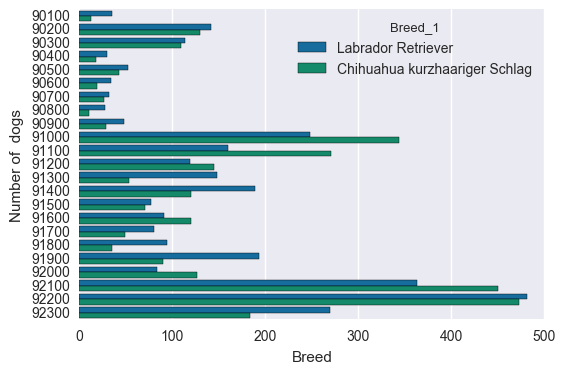

In [457]:
# Filter column with several values
labrador_vs_chihuahua = filtered_dogs[(filtered_dogs['Breed_1'].isin(['Chihuahua kurzhaariger Schlag', 'Labrador Retriever']))]
ax = sns.barplot(data=labrador_vs_chihuahua,palette='colorblind', x='Anzahl', hue='Breed_1', y='DISTRICT_CODE', orient='h')
ax.set(xlabel='Breed', ylabel='Number of  dogs')

In [441]:
district = 90100
dogs_district = filtered_dogs[(filtered_dogs['DISTRICT_CODE']==district)]
# dogs_01['Anzahl'].describe()
# dogs_01.sort_values(ascending=False, by='Anzahl')[['Dog Breed','Anzahl']].head()
total_dogs_district = sum(dogs_district['Anzahl'])
dogs_district['Percent'] = dogs_district['Anzahl'] / total_dogs_district * 100 
# dogs_01['Percent'].describe()
dogs_district[['Breed_1','Percent']].sort_values(ascending=False, by='Percent').round(1).head()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Breed_1,Percent
51,Labrador Retriever,10.5
28,Dackel,4.2
23,Chihuahua kurzhaariger Schlag,3.6
59,Malteser,3.6
48,Jack-Russell-Terrier,3.6


Wiener dog bits Chihuahua in the 1st district of Vienna!

In [405]:
district = 91500
dogs_district = filtered_dogs[(filtered_dogs['DISTRICT_CODE']==district)]
# dogs_01['Anzahl'].describe()
# dogs_01.sort_values(ascending=False, by='Anzahl')[['Dog Breed','Anzahl']].head()
total_dogs_district = sum(dogs_district['Anzahl'])
dogs_district['Percent'] = dogs_district['Anzahl'] / total_dogs_district * 100 
# dogs_01['Percent'].describe()
dogs_district[['Breed_1','Percent']].sort_values(ascending=False, by='Percent').round(1).head()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Breed_1,Percent
2007,Labrador Retriever,8.2
1965,Chihuahua kurzhaariger Schlag,7.4
2013,Malteser,7.0
2054,Yorkshire Terrier,4.9
1943,Amerikanischer Staffordshire-Terrier,4.7


### Open Data for Local Communities

In [350]:
# analyse district stats
district = 1190
dogs_district = filtered_dogs[(data['Postal_CODE']==district)][['Breed_1', 'Anzahl']]
top_dogs_district = dogs_district.sort_values(ascending=False, by='Anzahl')[:10]
top_dogs_district

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,Breed_1,Anzahl
4127,Labrador Retriever,102
4073,Golden Retriever,96
4118,Labrador Retriever,81
4023,Chihuahua kurzhaariger Schlag,77
4142,Malteser,57
4236,Yorkshire Terrier,46
4045,Deutscher SchÃ¤ferhund,44
4039,Dackel,39
4149,Mops,35
4104,Jack-Russell-Terrier,35


[<matplotlib.text.Text at 0x122678190>, <matplotlib.text.Text at 0x122672f10>]

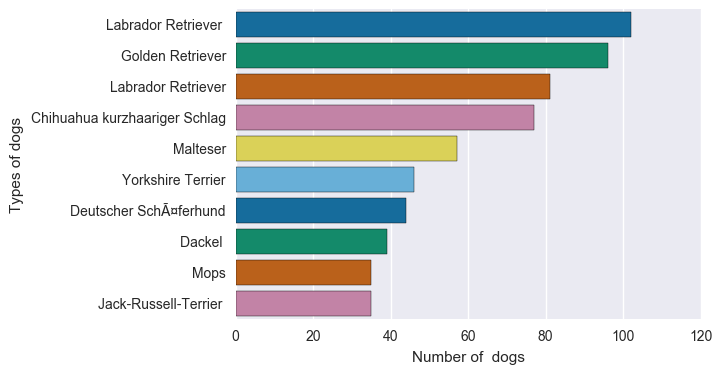

In [309]:
ax = sns.barplot(data=top_dogs_district,palette='colorblind', x='Anzahl', y='Breed_1')
ax.set(ylabel='Types of dogs', xlabel='Number of  dogs')

## Lessons Learned

### Dogs in Vienna

Based on the data available we were able to provide comprehensive answers to the set of research questions proposed in the introduction.

1. There are about 56 thousand dogs registered in Vienna of 1,060 different breeds.
2. Chihuahuas and Labradors are the top choices of Viennese people.
3. It is easy to spot the districts with specific dog breeds using open data, but the dog gender data is not available.
4. If you do not like dogs you probably want to leave in the 1st or 8th districts, where there are few dogs (everyone wants to live in the 1st or 8th districts anyway!). However, the major reason why there are few dogs there is that these districs are relatively small themselves (yes, they are part of the Old City center).
5. After correcting the number of dogs with the size of the population, 5th and 15th districts appear at the top of the dog-haters list. Why? Do people who do not like dogs tend to flock together or there are other factors influencing their decision not to have a dog? Maybe these numbers indicate that there are no proper facilities for having a dog in these districts (such as dog playgrounds)? You might want to reconsider your decision to move there if you prefer to have a dog.

### Open Data Quality
    1. Descriptions
    2. Formatting
    
### Process
    1. Find datasets, e.g. CSV files from open data portals
    2. Refine: 
        2.1. Process CSVs, i.e. identify column separator, thousands separator, rows to skip, string encoding, etc.
        2.2. Identify numeric data, e.g. sums or counts, that can be compared and aggregated.
        2.3. Split strings into several columns.
        2.4. Correct some data values manually.
    3. Slice: filter out rows, e.g. by district or type.
    4. Sort data by count (visualize ranking as a barplot).
    5. Aggregate: group by different attributes, e.g. district or type, and sum up the counts.
    6. Join datasets on the common key, e.g. district code identifier.
    7. Check correlations between columns.

## Inspired by
1. [Detail Analysis of various Hospital factors](https://www.kaggle.com/nirajvermafcb/d/cms/hospital-general-information/detail-analysis-of-various-hospital-factors)
2. Wheelan, Charles J. Naked Statistics. 2013